# CA1 Part3: LDA based data distribution visualization

In [2]:
import os
import sys
import cv2
import json
import numpy as np
from scipy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
from mpl_toolkits.mplot3d import Axes3D
from goto import with_goto
from math import log
import pandas as pd

In [3]:
# training image class
class Ti:
    def __init__(self):
        self.img = [] # pixel values
        self.feature = [] # feature vecter
        self.di = [] # dimensionality reduced feature
        self.id = 0 # -1 belongs to me
        self.trans = [] # data transform to new space
        self.prediction = 0 # predicted label only valid for test data
        

In [4]:
# collect all traning set data 
def alldata():
    # load current directory
    cur_dir = os.path.dirname(os.path.abspath("CA2_Part1.ipynb"))
    # PIE directory
    PIE_dir = cur_dir + '/PIE'
    # load json folder
    json_dir = PIE_dir + '/json'
    # read json files' name
    datanames = os.listdir(json_dir)
    datanames.remove('Me')
    datanames.remove('.DS_Store')

    # load all PIE data
    PIE_img = []
    for person in datanames:
        jsonfile = open(json_dir+'/'+person)
        img = json.load(jsonfile)

        # store the image information in class
        for im in img: 
            sample = Ti()
            sample.img = im
            sample.id = int(person)
            PIE_img.append(sample)
            
    # show the id of the data
    ID = []
    for sample in PIE_img:
        ID.append(sample.id)
    person = list(set(ID))
    person = sorted(person)
    print(person)

    ####
    # load my photo data set
    ####
    me_img = []
    jsonfile = open(json_dir+'/Me')
    img = json.load(jsonfile)

    # store the image information in class
    for im in img: 
        sample = Ti()
        sample.img = im
        sample.id = -1
        me_img.append(sample)
        
    return PIE_img, me_img

In [5]:
# select some dubjects in all data
def dataselect(data,num,ID = None):
    
    # input protect
    allID = []
    for sample in data:
        allID.append(sample.id)
    person = list(set(allID))
    
    if ID != None:
        # check inputs
        if len(ID) != num:
            raise ValueError('Input attributes not match!')
        for i in ID:
            if i not in person:
                raise ValueError('Input ID not exist!')
                
    else:
        ID = sorted(random.sample(person,num))
        print('Random selected id is :',ID)
    
    # select data with certain selected id  
    data_set = []
    for sample in data:
        if sample.id in ID:
            data_set.append(sample)
            
    return data_set, ID

In [6]:
# generate num numbers whose total is summary
# least : min value of every number
def sumran(num,summary,least = 1):
#     print(num,summary,least)
    n = num - 1
    loops = 0
    if summary/num < least:
        raise ValueError("input attributes are not resonable")
        
    elif int(summary/num) * 0.95 <= least:
        output = list(np.ones(num) * int(summary/num))
    
    else:
        while True:
            loops += 1
            points = random.sample(range(least,summary - least),n)
            points = sorted(points)
            points = [0] + points + [summary]

            output = []
            for i in range(1,num+1):
                output.append(points[i] - points[i-1])

            if min(output) > least:
                print(output)
                break
            elif loops > 10e8:
                raise ValueError("input attributes are not resonable")
        
    return output

In [7]:
# feature matrix generater
def Gfeature(data):

    size = len(data)
    fm = np.zeros([size,1024])
    # collect the id of data
    ID = np.zeros(size)
    for i in range(size):
        sample = data[i]
        if len(sample.feature) == 0:
            img = np.array(sample.img)
            feature = img.reshape(1,-1)
            sample.feature = list(feature)
            fm[i,:] = feature
            pid = sample.id
            ID[i] = pid
        elif len(sample.feature) == 1024:
            fm[i,:] = np.array(sample.feature)
            pid = sample.id
            ID[i] = pid
        else:
            img = np.array(sample.img)
            feature = img.reshape(1,-1)
            sample.feature = list(feature)
            fm[i,:] = feature
            pid = sample.id
            ID[i] = pid
        
    index = np.argsort(ID)
    fm = fm[index,:]
    ID = ID[index]
    
    return fm,ID,index

In [8]:
# get training data set and test data set
# ran_num == None : all data will be taken
def dataset(data,ran_per = None,ran_num = None,train_percent = 0.7,least_sample = 10):
    
    ID = []
    for sample in data:
        ID.append(sample.id)
    strID = [str(i) for i in ID]
    person = list(set(ID))
      
    if ran_num == None or ran_per == None:
        train_set = []
        test_set = []
        for ran_id in person:
            # get samples belongs to this id
            str_id = str(ran_id)
            sample_sum = strID.count(str_id)
            index_start = ID.index(ran_id)
            index_end = index_start + sample_sum
            id_samples = data[index_start:index_end]
            # random samples
            ran_id_samples = random.sample(id_samples,sample_sum)

            # generate data set
            train_num = round(train_percent * sample_sum) 
            train_set = train_set + ran_id_samples[:train_num]
            test_set = test_set + ran_id_samples[train_num:sample_sum]
        
    else:           
        flag = True
        loops = 0
        while flag:
            loops += 1
            print("trying to generate dataset: attempt ",loops)
            flag = False
            sel_id = random.sample(person,ran_per)

            # get number of images of every id 
            distribution = sumran(ran_per,ran_num,least = least_sample)
            
            train_set = []
            test_set = []
            # get the random samples
            for i in range(0,len(sel_id)):
                ran_id = sel_id[i]
                sample_num = distribution[i]
                str_id = str(ran_id)
                sample_sum = strID.count(str_id)
                
                # abnormal address
                if sample_sum < sample_num:
                    print("ab")
                    avalible = distribution[i:]
                    
                    if len(avalible) < 2:
                        flag = True
                        break
                    
                    min_ava = min(avalible)
                    if min_ava > sample_sum:
                        flag = True
                        break
                        
                    else:
                        # interchange the value in distribution
                        min_index = avalible.index(min_ava)
                        current_value = sample_num
                        avalible[0] = min_ava
                        avalible[min_index] = current_value
                        # change the value
                        distribution = distribution[:i] + avalible
                
                # reget sample number
                sample_num = int(distribution[i])        
                # get samples belongs to this id
                index_start = ID.index(ran_id)
                index_end = index_start + sample_sum
                id_samples = data[index_start:index_end]
                # random samples
#                 print(id_samples,sample_num)
                ran_id_samples = random.sample(id_samples,sample_num)
                
                # generate data set
                train_num = round(train_percent * sample_num) 
                train_set = train_set + ran_id_samples[:train_num]
                test_set = test_set + ran_id_samples[train_num:sample_sum]
            
            if loops > 500:
                raise ValueError("input attributes are not resonable")
    
    random.shuffle(train_set)
    random.shuffle(test_set)
    print("Done")
    
    return train_set,test_set

In [9]:
def pca(train, num_feat = None):
    # get data matrix
    data,_,index_train = Gfeature(train)
    # input protect
    [row,col] = data.shape
    if num_feat == None:     
        num_feat = col
    # remove the average
    avg = np.mean(data,axis=0) 
    re_data = data - avg
    # calculate covariance
    cov_data = np.cov(re_data,rowvar=0)  
    # calculate eigenvalue
    eig_val, eig_vect = linalg.eig(np.mat(cov_data)) 
    # sort eigenvalue index form max to min
    eig_sorted = np.argsort(-eig_val)  
    
    # select component with contribution over 0.95
    if num_feat == None:
        sum_eig = np.sum(eig_val)
        ratio = 0
        num_feat = 0
        while(ratio < 0.95):
            num_feat += 1
            ratio = np.sum(eig_val[0:num_feat])/sum_eig
            
    P = eig_vect[:,eig_sorted] 
    # calculate reduced dimentional data
    re_dim = np.dot(re_data,P).real  
    # transform data to new dimentionality
    trans_data = np.dot(re_dim,P.T) + avg  
    # reduced dimentional data
    reduced = re_dim[:,:num_feat]
    
    # store the di and trans
    for i in range(row):
        index = index_train[i]
        sample = train[index]
        sample.di = re_dim[i].tolist()
        sample.trans = trans_data[i].tolist()
    
    return reduced, P, avg, num_feat

In [10]:
def LDA(train, num_feat = None):
    # get data matrix
    data,ID,index_train = Gfeature(train)
    [row,col] = data.shape
    
    # seperate the feature matrix by id
    listID = list(ID)
    person = list(set(ID))
    person = sorted(person)
    class_fm = []
    N = []
    for i in range(0,len(person)-1):
        index_start = listID.index(person[i])
        index_end = listID.index(person[i+1])
        Ni = index_end - index_start
        class_fm.append(data[index_start:index_end,:])
        N.append(Ni)
    class_fm.append(data[index_end:,:])
    Ni = row - index_end
    N.append(Ni)
        
    # input protect 
    if num_feat == None:
        num_feat = len(person) - 1
    # calculate the average of all samples
    avg_all = np.mean(data,axis=0) 
    # calculate the average of every class
    class_avg = []
    for child_fm in class_fm:
        avg = np.mean(child_fm,axis=0)
        class_avg.append(avg)
    # calculate Sw
    Sw = np.zeros([col,col])
    for child_fm in class_fm:
        Si = np.cov(child_fm.T)
        Sw += Si
    # calculate Sb
    Sb = np.zeros([col,col])
    for i in range(len(person)):
        Sb += N[i] * np.dot((class_avg - avg_all).T,(class_avg - avg_all))
    # calculate SwSb
    # if there is nan in Sw, turn it into beta
    beta = 10e-3
    Sw[np.isnan(Sw)] = beta
    SwSb = np.dot(linalg.inv(Sw),Sb) 
    # calculate eigenvalue
    eig_val, eig_vect = linalg.eig(SwSb) 
    # sort eigenvalue index form max to min
    eig_sorted = np.argsort(-eig_val)  
    
    # select component with contribution over 0.999
    if num_feat == -1:
        sum_eig = np.sum(eig_val)
        ratio = 0
        num_feat += 1
        while(ratio < 0.999):
            num_feat += 1
            ratio = np.sum(eig_val[0:num_feat])/sum_eig
            
    W = eig_vect[:,eig_sorted]   
    # transform data to new dimentionality
    trans_data = np.dot(data,W.T)   
    # reduced dimentional data
    reduced = trans_data[:,:num_feat]
    
    # store the di and trans
    for i in range(row):
        index = index_train[i]
        sample = train[index]
        sample.di = list(trans_data[i])
        sample.trans = list(reduced[i])
    
    return reduced, W, num_feat

In [11]:
# fit test data
def fittingLDA(train, test, feature_dimension = None, K = 1):
    
    #
    # training model
    #
    _,W,feature_dimension = LDA(train,feature_dimension)
    print('feature_dimension = ',feature_dimension)
    print('Training done!')
    
    #
    # test data feature generation 
    #
    # get test matrix
    test_m,_,index_test = Gfeature(test)
    [row,col] = test_m.shape
    
    # transform data to new dimentionality
    trans_data = np.dot(test_m,W.T)
    # reduced dimentional data
    reduced = trans_data[:,:feature_dimension]
    
    # store the di and trans
    for i in range(row):
        index = index_test[i]
        sample = test[index]
        sample.di = list(trans_data[i])
        sample.trans = list(reduced[i])
        
    print('Testing done!')
        
    #
    # get predicted label
    #
    mtrain = np.mat(np.zeros(feature_dimension))
    for sample in train:
        mtrain = np.concatenate((mtrain,np.mat(sample.di[:feature_dimension])),axis = 0)
    mtrain = np.mat(mtrain)
    mtrain = mtrain[1:]
#     print(mtrain.shape,len(train))

#     i = 0
    for sample in test:
        label = KNN(train,sample,feature_dimension,K,train_m = mtrain)
        sample.prediction = label
#         i += 1
#         if i % int(row/10) == 0:
#             print('Prediction complete %.2f%%' % ( i / row ) * 100 + '\n' )
    
    print('Prediction done!')

In [12]:
# fit test data
def fittingPCA(train, test, feature_dimension = None, K = 1):
    
    #
    # training model
    #
    # training model
    _,P,avg,feature_dimension = pca(train,feature_dimension)
    print('Training done!')

    # remove average value
    re_test = test_m - avg
    # calculate reduced dimentional data
    re_dim = np.dot(re_test,P).real  
    # transform data to new dimentionality
    trans_data = np.dot(re_dim,P.T) + avg

    # store the di and trans
    for i in range(row):
        index = index_test[i]
        sample = test[index]
        sample.di = re_dim[i].tolist()
        sample.trans = trans_data[i].tolist()

    print('Testing done!')
        
    #
    # get predicted label
    #
    mtrain = np.mat(np.zeros(feature_dimension))
    for sample in train:
        mtrain = np.concatenate((mtrain,np.mat(sample.di[:feature_dimension])),axis = 0)
    mtrain = np.mat(mtrain)
    mtrain = mtrain[1:]
#     print(mtrain.shape,len(train))

#     i = 0
    for sample in test:
        label = KNN(train,sample,feature_dimension,K,train_m = mtrain)
        sample.prediction = label
#         i += 1
#         if i % int(row/10) == 0:
#             print('Prediction complete %.2f%%' % ( i / row ) * 100 + '\n' )
    
    print('Prediction done!')

In [13]:
# feature matrix generater
def Gtrans(data):

    size = len(data)
    length = len(data[0].trans)
    fm = np.zeros([size,length])
    # collect the id of data
    ID = np.zeros(size)
    for i in range(size):
        sample = data[i]
        transform = sample.trans
        transform = np.mat(transform)
        fm[i,:] = transform
        pid = sample.id
        ID[i] = pid
        
    index = np.argsort(ID)
    fm = fm[index,:]
    ID = ID[index]
    
    return fm,ID,index

## Read all the data

In [14]:
PIE,Me = alldata()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


## Select 25 subjects in all 

In [15]:
# randomly select
data,selected = dataselect(PIE,25) 

Random selected id is : [3, 5, 6, 9, 12, 13, 14, 17, 21, 22, 24, 25, 30, 31, 32, 36, 37, 40, 41, 42, 51, 53, 57, 64, 65]


# 2D Visualization

In [16]:
train,test = dataset(data,ran_per = 10,ran_num = 500,train_percent = 0.7,least_sample = 50)
Me_train,Me_test = dataset(Me,train_percent = 0.7)

show = train + Me_train
fm,W,feature_dimension = LDA(show,num_feat = 2)

# fm,ID,_ = Gtrans(show)

mypoint = fm[:len(Me_train),:]
otherspoint = fm[len(Me_train):,:]

trying to generate dataset: attempt  1
Done
Done


/Users/wanrylin/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


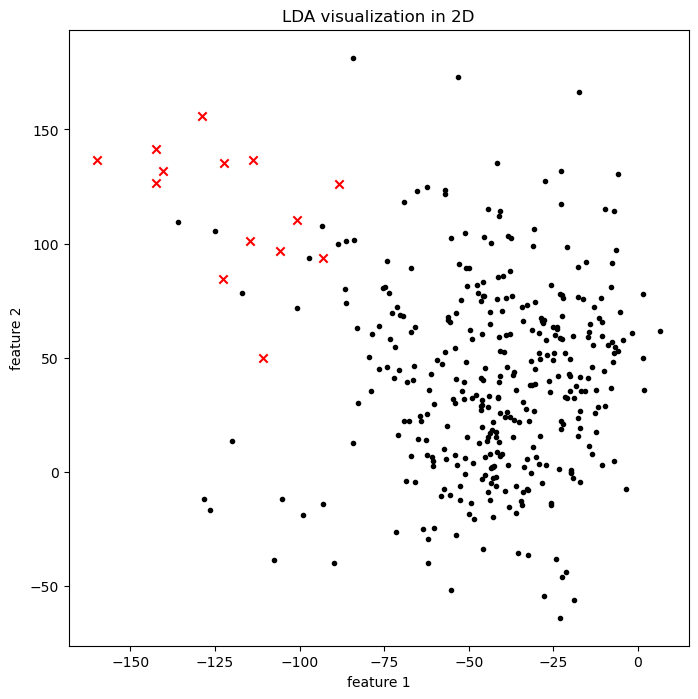

In [17]:
plt.figure( figsize=(8,8) )
plt.scatter(otherspoint[:,0],otherspoint[:,1],c = 'k',marker = '.')
plt.scatter(mypoint[:,0],mypoint[:,1],c = 'r',marker = 'x')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("LDA visualization in 2D")
plt.show()

In [18]:
fm,P,avg,feature_dimension = pca(show,num_feat = 2)

mypoint = fm[:len(Me_train),:]
otherspoint = fm[len(Me_train):,:]

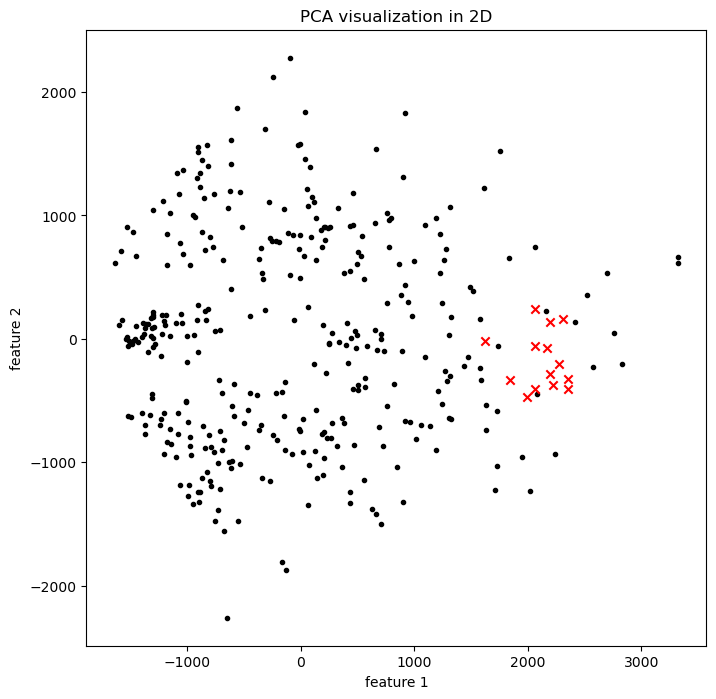

In [20]:
plt.figure( figsize=(8,8) )
plt.scatter(otherspoint[:,0],otherspoint[:,1],c = 'k',marker = '.')
plt.scatter(mypoint[:,0],mypoint[:,1],c = 'r',marker = 'x')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("PCA visualization in 2D")
plt.show()

# 3D Visualization

In [26]:
fm,W,feature_dimension = LDA(show,num_feat = 3)

# fm,ID,_ = Gtrans(show)

mypoint = fm[:len(Me_train),:]
otherspoint = fm[len(Me_train):,:]

/var/folders/l5/222hwgzd5nz4v415zl9k5_5w0000gn/T/ipykernel_865/3512058178.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


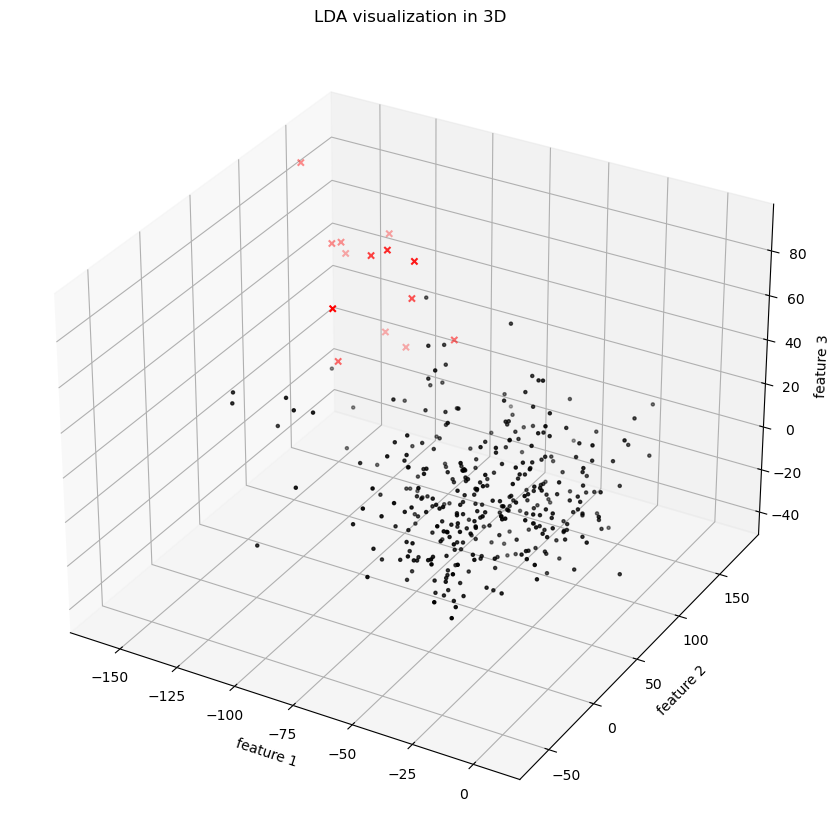

In [27]:
fig = plt.figure( figsize=(8,8) )
ax = Axes3D(fig)
ax.scatter(otherspoint[:,0],otherspoint[:,1],otherspoint[:,2],c = 'k',marker = '.')
ax.scatter(mypoint[:,0],mypoint[:,1],mypoint[:,2],c = 'r',marker = 'x')
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("feature 3")
ax.set_title("LDA visualization in 3D")
plt.show()

In [30]:
fm,P,avg,feature_dimension = pca(show,num_feat = 3)

mypoint = fm[:len(Me_train),:]
otherspoint = fm[len(Me_train):,:]

/var/folders/l5/222hwgzd5nz4v415zl9k5_5w0000gn/T/ipykernel_865/3177786344.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


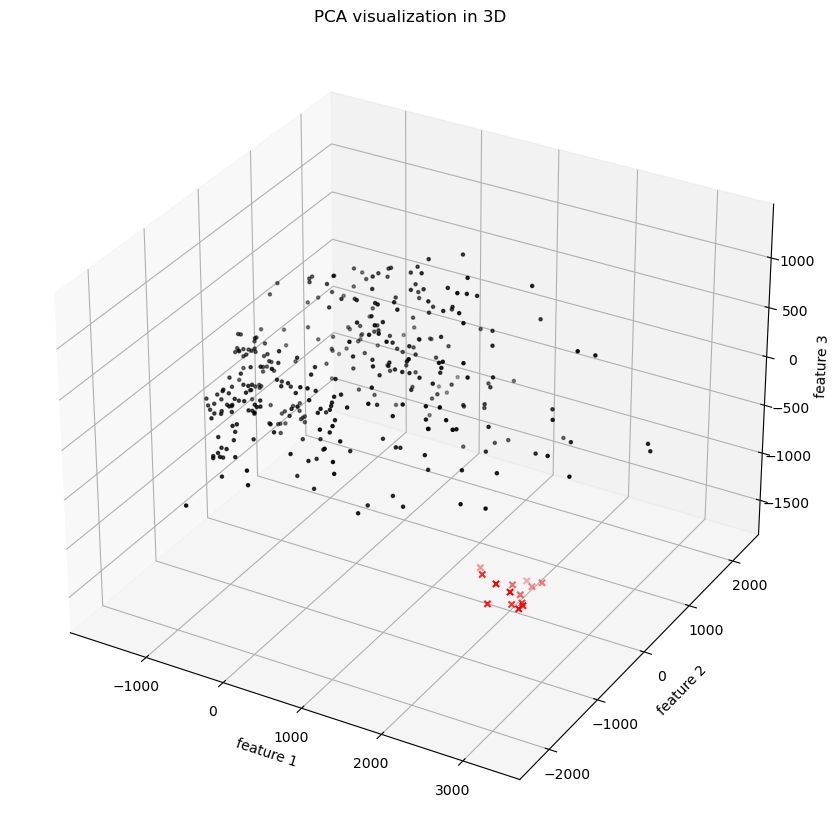

In [32]:
fig = plt.figure( figsize=(8,8) )
ax = Axes3D(fig)
ax.scatter(otherspoint[:,0],otherspoint[:,1],otherspoint[:,2],c = 'k',marker = '.')
ax.scatter(mypoint[:,0],mypoint[:,1],mypoint[:,2],c = 'r',marker = 'x')
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("feature 3")
ax.set_title("PCA visualization in 3D")
plt.show()

# evaluate the mean and variance of the images of data set

In [35]:
allfeature,_,_ = Gfeature(data)

In [38]:
avg = np.mean(allfeature, axis = 1)
variance = np.var(allfeature, axis = 1)

In [41]:
print('the variance of the average value of all samples',np.var(avg))
print('the variance of the variance value of all samples',np.var(variance))

the variance of the average value of all samples 971.8932870184626
the variance of the variance value of all samples 1231701.6969136673
